In [1]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
plt.style.use('ggplot')

## Difference Between Tensor and Python Variable

In [3]:
var = 1.
print("python variable: ", var)
print()

var_tensor = tf.constant(1.)
print("tensor: ", var_tensor)

python variable:  1.0

tensor:  Tensor("Const:0", shape=(), dtype=float32)


In [4]:
with tf.Session() as sess:
    print("透過tensorflow session取得tensor value: ", sess.run(var_tensor))

透過tensorflow session取得tensor value:  1.0


<br/>
<br/>
<br/>
## Simple Regression Example
- Formula: $ Y = 0.5X + 0.3 $

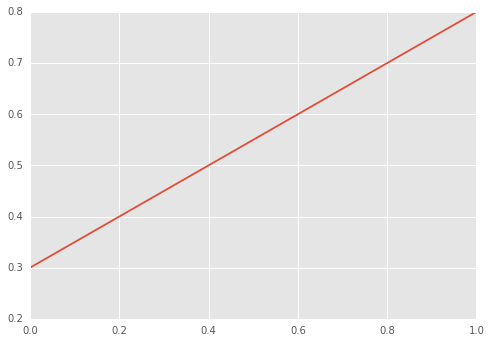

In [5]:
formula = lambda x: 0.5 * x + 0.3
data_x = np.linspace(0, 1, 100)
plt.plot(data_x, formula(data_x)) # np.random.normal(0., 0.01, len(data_x)), linewidths=1
plt.show()

In [6]:
import tensorflow as tf, numpy as np

n_epoch = 200
learning_rate = 0.5

outerX = np.random.random(10000)
outerY = 0.5 * outerX + 0.3
outerX, outerY

model_dir = "./model/linear"

tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    with tf.variable_scope("inputs"):
        # 接收 outerX data
        placeholderX = tf.placeholder(tf.float32, shape=[None], name="placeholder_x")
        # 接收 outerY data
        placeholderY = tf.placeholder(tf.float32, shape=[None], name="placeholder_y")
        
    with tf.variable_scope("formula"):
        varW = tf.Variable(tf.random_uniform(shape=[1]), tf.float32, name="var_w")
        varB = tf.Variable(tf.random_uniform(shape=[1]), tf.float32, name="var_b")
        # 公式 0.5X + 0.3, 期望varW會慢慢逼近5, varB會慢慢逼近0.3
        varY = varW * placeholderX + varB
        # tensorboard weights logs
        tf.summary.histogram("varW", varW)
        tf.summary.histogram("varB", varB)
    # mean square error
    loss = tf.losses.mean_squared_error(placeholderY, varY)
    # tensorboard weights logs
    tf.summary.scalar("loss", loss)
    # 使用 GradientDescentOptimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    # 最小化 loss, 此時會 backpropagation 去調整 varW, varB的值
    trainer = optimizer.minimize(loss)
    merge = tf.summary.merge_all()
    
    with tf.Session(graph=g) as sess:
        w = tf.summary.FileWriter("./model/linear", sess.graph)
        init = tf.global_variables_initializer()
        sess.run(init)
        for i in range(n_epoch):
            _, w_, b_ = sess.run([trainer, varW, varB], feed_dict={placeholderX: outerX, placeholderY: outerY})
            print('step: {} varW: {}, varB: {}'.format(i, w_, b_) )
            if (i + 1) % 20 == 0:
                merge_ = sess.run(merge, feed_dict={placeholderX: outerX, placeholderY: outerY})
                w.add_summary(merge_, i)

step: 0 varW: [ 0.8238861], varB: [ 0.11188183]
step: 1 varW: [ 0.80947953], varB: [ 0.13649985]
step: 2 varW: [ 0.78751045], varB: [ 0.14377239]
step: 3 varW: [ 0.76928866], varB: [ 0.15486255]
step: 4 varW: [ 0.7516216], varB: [ 0.16406105]
step: 5 varW: [ 0.73527688], varB: [ 0.1729795]
step: 6 varW: [ 0.71994936], varB: [ 0.18123046]
step: 7 varW: [ 0.70563251], varB: [ 0.1889679]
step: 8 varW: [ 0.69224429], varB: [ 0.19619516]
step: 9 varW: [ 0.67972863], varB: [ 0.20295362]
step: 10 varW: [ 0.66802752], varB: [ 0.20927162]
step: 11 varW: [ 0.65708828], varB: [ 0.21517843]
step: 12 varW: [ 0.6468612], varB: [ 0.22070065]
step: 13 varW: [ 0.63729995], varB: [ 0.22586335]
step: 14 varW: [ 0.62836117], varB: [ 0.23068994]
step: 15 varW: [ 0.62000436], varB: [ 0.23520231]
step: 16 varW: [ 0.61219156], varB: [ 0.23942089]
step: 17 varW: [ 0.60488743], varB: [ 0.24336486]
step: 18 varW: [ 0.59805882], varB: [ 0.24705203]
step: 19 varW: [ 0.5916748], varB: [ 0.25049916]
step: 20 varW: [

## Check Tensorboard

In [14]:
from google.datalab.ml import TensorBoard

tb = TensorBoard()
# stop prev built tensorboard pid
for _, r in tb.list().iterrows(): tb.stop(r.pid)

tb.start(model_dir)
tb.list()

TensorBoard was started successfully with pid 9595. Click here to access it.

,logdir,pid,port
0,./model/linear,9595,50667


## Stop Tensorboard

In [10]:
for _, r in tb.list().iterrows(): tb.stop(r.pid)

<br/>
<br/>
<br/>
<br/>
<br/>
## Model Save and Load

In [11]:
import tensorflow as tf, numpy as np

class LinearModel(object):
    def __init__(self):
        """Init graph"""
        tf.reset_default_graph()
        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.variable_scope("inputs"):
                # 接收 outerX data
                self.placeholderX = tf.placeholder(tf.float32, shape=[None], name="placeholder_x")
                # 接收 outerY data
                self.placeholderY = tf.placeholder(tf.float32, shape=[None], name="placeholder_y")

            with tf.variable_scope("formula"):
                self.varW = tf.Variable(tf.random_uniform(shape=[1]), tf.float32, name="var_w")
                self.varB = tf.Variable(tf.random_uniform(shape=[1]), tf.float32, name="var_b")
                self.varY = self.varW * self.placeholderX + self.varB
                # tensorboard weights logs
                tf.summary.histogram("varW", varW)
                tf.summary.histogram("varB", varB)
            # 均方誤差
            self.loss = tf.losses.mean_squared_error(self.placeholderY, self.varY)
            # tensorboard weights logs
            tf.summary.scalar("loss", self.loss)
            # 使用 AdamOptimizer
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            # 最小化 loss, 此時會 backpropagation 去調整 varW, varB的值
            self.trainer = self.optimizer.minimize(self.loss)
            self.merge = tf.summary.merge_all()
            # 儲存物件
            self.saver = tf.train.Saver(tf.global_variables())
            
    def load_weight(self, sess, model_dir):
        """load latest saved model"""
        latestCkpt = tf.train.latest_checkpoint(model_dir)
        if latestCkpt:
            self.saver.restore(sess, latestCkpt)
            print("load weight success!")
        return latestCkpt

## Save Model

In [15]:
n_epoch = 200
learning_rate = 0.01

outerX = np.random.random(10000)
outerY = 0.5 * outerX + 0.3
outerX, outerY

model_dir = "./model/linear"

model = LinearModel()
with tf.Session(graph=model.graph) as sess:
    w = tf.summary.FileWriter(model_dir, sess.graph)
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(n_epoch):
        _, w_, b_ = sess.run([model.trainer, model.varW, model.varB], feed_dict={model.placeholderX: outerX, model.placeholderY: outerY})
        print('step: {} varW: {}, varB: {}'.format(i, w_, b_) )
        if (i + 1) % 50 == 0:
            merge_ = sess.run(model.merge, feed_dict={model.placeholderX: outerX, model.placeholderY: outerY})
            w.add_summary(merge_, i)
            
        if (i + 1) % 50 == 0:
            ''' Save model '''
            model.saver.save(sess, save_path=model_dir + "/linear_model", global_step=i)

step: 0 varW: [ 0.30896211], varB: [ 0.14444292]
step: 1 varW: [ 0.31894305], varB: [ 0.15442356]
step: 2 varW: [ 0.32889062], varB: [ 0.16437024]
step: 3 varW: [ 0.33878919], varB: [ 0.17426699]
step: 4 varW: [ 0.34862161], varB: [ 0.18409631]
step: 5 varW: [ 0.35836929], varB: [ 0.19383913]
step: 6 varW: [ 0.36801216], varB: [ 0.20347492]
step: 7 varW: [ 0.37752861], varB: [ 0.21298148]
step: 8 varW: [ 0.38689551], varB: [ 0.22233503]
step: 9 varW: [ 0.39608836], varB: [ 0.2315103]
step: 10 varW: [ 0.40508127], varB: [ 0.24048059]
step: 11 varW: [ 0.41384718], varB: [ 0.24921794]
step: 12 varW: [ 0.42235813], varB: [ 0.25769341]
step: 13 varW: [ 0.43058544], varB: [ 0.26587737]
step: 14 varW: [ 0.43850026], varB: [ 0.27373984]
step: 15 varW: [ 0.44607386], varB: [ 0.28125104]
step: 16 varW: [ 0.45327824], varB: [ 0.28838193]
step: 17 varW: [ 0.4600867], varB: [ 0.29510477]
step: 18 varW: [ 0.46647441], varB: [ 0.30139384]
step: 19 varW: [ 0.47241905], varB: [ 0.307226]
step: 20 varW:

## Load Model

INFO:tensorflow:Restoring parameters from ./model/linear/linear_model-199
load weight success!


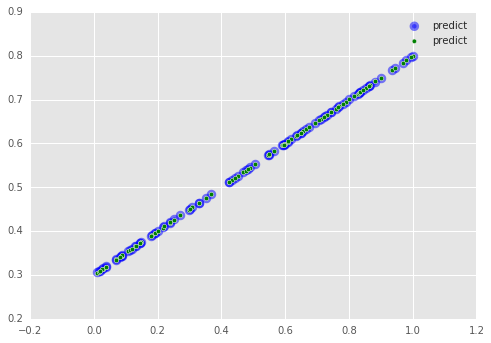

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

model_dir = "./model/linear"
data_x = np.random.random(100)

model = LinearModel()
with tf.Session(graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    ''' load pre-trained weight into model '''
    model.load_weight(sess, model_dir)
    ''' ################################## '''
    
    y = sess.run(model.varY, feed_dict={model.placeholderX: data_x})
    
    ans_y = lambda x: 0.5 * x + 0.3
    plt.scatter(data_x, y, label="predict", color="b", linewidth=5, alpha=0.5)
    plt.scatter(data_x, ans_y(data_x), label="predict", c="g")
    plt.legend(loc="best")
    plt.show()

## Observations
1. 上圖可知, 預測的答案跟實際答案是重疊的, 代表Model load success